<a href="https://colab.research.google.com/github/wayne0git/signal_image_process/blob/main/jpeg_encode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JPEG Encode
- Ref : https://www.hdm-stuttgart.de/~maucher/Python/MMCodecs/html/jpegUpToQuant.html

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Constant

In [11]:
# JPEG Block size
B = 8

# JPEG Quality factor
QF = 99.0   # 1 ~ 99

In [10]:
# Quantization Table (Luma / Chroma)
QY=np.array([[16,11,10,16,24,40,51,61],
      [12,12,14,19,26,48,60,55],
      [14,13,16,24,40,57,69,56],
      [14,17,22,29,51,87,80,62],
      [18,22,37,56,68,109,103,77],
      [24,35,55,64,81,104,113,92],
      [49,64,78,87,103,121,120,101],
      [72,92,95,98,112,100,103,99]])

QC=np.array([[17,18,24,47,99,99,99,99],
      [18,21,26,66,99,99,99,99],
      [24,26,56,99,99,99,99,99],
      [47,66,99,99,99,99,99,99],
      [99,99,99,99,99,99,99,99],
      [99,99,99,99,99,99,99,99],
      [99,99,99,99,99,99,99,99],
      [99,99,99,99,99,99,99,99]])

## 1. Read data

In [2]:
img = cv2.imread('lena.jpg')

## 2. Color Conversion (RGB => YCbCr) (With chroma subsample, 420)

In [4]:
img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

In [8]:
# Apply 2 * 2 average before 2x subsample
cr_sub = cv2.boxFilter(img_ycrcb[..., 1], ddepth=-1, ksize=(2, 2))[::2, ::2]
cb_sub = cv2.boxFilter(img_ycrcb[..., 2], ddepth=-1, ksize=(2, 2))[::2, ::2]

In [9]:
# Concatenate Y / Cr / Cb
img_ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
ycrcb = [img_ycrcb, cr_sub, cb_sub]

## 3. DCT & Quantization

In [16]:
# Adjust quantization table based on quality factor
def get_scale(qf):
    if qf < 50 and qf >= 1:
        return np.floor(5000 / qf) / 100.0
    elif qf < 100:
        return (200 - 2 * qf) / 100.0
    else:
        print('Quality Factor must be in the range [1..99]')
        return 1

scale = get_scale(QF)
q_table = [QY * scale, QC * scale, QC * scale]

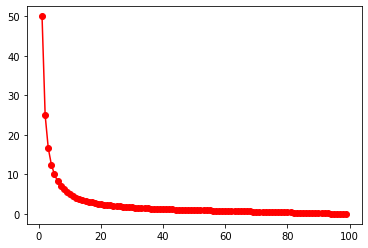

In [17]:
plt.plot(range(1, 100), [get_scale(q) for q in range(1, 100)], 'ro-')

In [ ]:
# Apply DCT and quantization
TransAll=[]
TransAllQuant=[]
ch=['Y','Cr','Cb']

for channel in ycrcb:
    n_row, n_col = channel.shape
    Trans = np.zeros((n_row, n_col), np.float32)
    TransQuant = np.zeros((n_row, n_col), np.float32)
    blocksV = n_row/B
    blocksH = n_col/B
    vis0 = np.zeros((channelrows,channelcols), np.float32)
    vis0[:channelrows, :channelcols] = channel
    vis0=vis0-128
    for row in range(blocksV):
        for col in range(blocksH):
            currentblock = cv2.dct(vis0[row*B:(row+1)*B,col*B:(col+1)*B])
            Trans[row*B:(row+1)*B,col*B:(col+1)*B]=currentblock
            TransQuant[row*B:(row+1)*B,col*B:(col+1)*B]=np.round(currentblock/Q[idx])
    TransAll.append(Trans)
    TransAllQuant.append(TransQuant)
    if idx==0:
        selectedTrans=Trans[srow*B:(srow+1)*B,scol*B:(scol+1)*B]
    else:
        sr=np.floor(srow/SSV)
        sc=np.floor(scol/SSV)
        selectedTrans=Trans[sr*B:(sr+1)*B,sc*B:(sc+1)*B]